## <font color='limegreen'>HIRING DEMAND FORECASTING</font>
### <font color='limegreen'>II - STATISTICAL MODELS</font>

In [1]:
# Python Language Version
from platform import python_version
print('The python version used in this jupyter notebook:', python_version())

The python version used in this jupyter notebook: 3.13.5


### 1. LOAD PACKAGES

#### Import packages

In [2]:
%%capture output
!pip install -q -r requirements.txt

In [3]:
from utils import *

### 2. LOAD DATA

In [4]:
# Load original
df_origin = pd.read_csv('../data/contratacoes.csv')

In [5]:
# Original copy
df = df_origin.copy()

### 3. UNDERSTANDE AND PROCESS DATA

In [6]:
df.head()

,data,contratacoes
0,2020-01-01,241.0
1,2020-01-02,175.0
2,2020-01-03,235.0
3,2020-01-04,117.0
4,2020-01-05,124.0


In [7]:
df.shape

(1886, 2)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1886 entries, 0 to 1885
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   data          1886 non-null   object 
 1   contratacoes  1708 non-null   float64
dtypes: float64(1), object(1)
memory usage: 29.6+ KB


In [9]:
# Time series period
print(f"Time series period: {df['data'].min()} to {df['data'].max()}")

Time series period: 2020-01-01 to 2025-02-28


In [10]:
# Convert 'data' variable to datetime and index
df['data'] = pd.to_datetime(df['data'], format='%Y-%m-%d')
df = df.set_index('data').asfreq('D')

In [11]:
df.head()

,contratacoes
data,
2020-01-01,241.0
2020-01-02,175.0
2020-01-03,235.0
2020-01-04,117.0
2020-01-05,124.0


### 4. SUMMARY OF DATA CARACTERITICS

A série temporal univariada abrange o período de 01/01/2020 a 28/02/2025, totalizando 1.886 registros. O conjunto de dados contém as variáveis 'data' (índice datetime) e 'contratacoes'. A série apresenta uma distribuição não normal, com assimetria à direita, padrões não lineares, e a presença de outliers. Apesar dessas características, a série é estacionária, homocedástica, exibindo sazonalidade, uma tendência de crescimento e correlação significativa.

### 5. DATA DIVISION

In [12]:
# Data division
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.15)

train = df.iloc[:train_size]
val = df.iloc[train_size:train_size + val_size]
test = df.iloc[train_size + val_size:]

# Verification of indexes
if train.index.is_monotonic_increasing and val.index.is_monotonic_increasing and test.index.is_monotonic_increasing:
    print("Indices are correctly ordered.")
else:
    print("Warning: indices are not in ascending order or have gaps.")

Indices are correctly ordered.


### 6. STATISTICAL MODELING

#### 6.1. ARIMA MODEL
Benchmark model

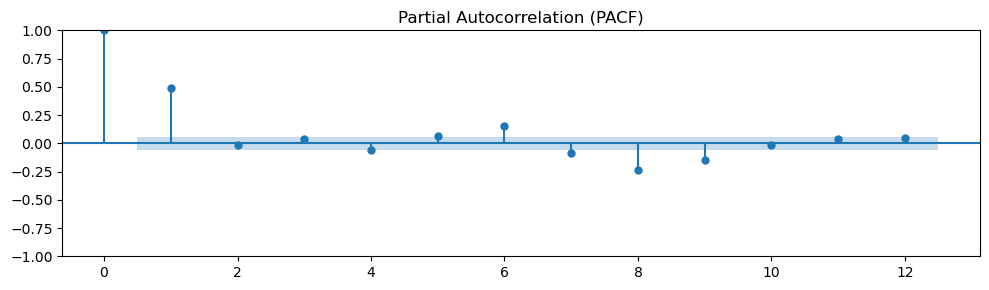

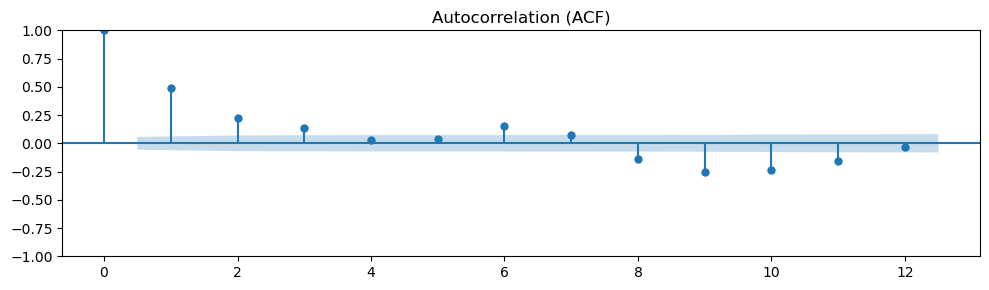

In [13]:
# ACF and PACF analysis (training data)
pacf_values = pacf(train['contratacoes'].dropna(), nlags=12)
acf_values = acf(train['contratacoes'].dropna(), nlags=12)

# PACF Plot
plt.figure(figsize=(10, 3))
plot_pacf(train['contratacoes'].dropna(), lags=12, ax=plt.gca(), method='ywm')
plt.title('Partial Autocorrelation (PACF)')
plt.tight_layout()
plt.show()

# Plot ACF
plt.figure(figsize=(10, 3))
plot_acf(train['contratacoes'].dropna(), lags=12, ax=plt.gca())
plt.title('Autocorrelation (ACF)')
plt.tight_layout()
plt.show()

In [14]:
# ARIMA Model 
# Configuration 
order = (6, 0, 6)  # (p, d, q)

model_arima = SARIMAX(train['contratacoes'],
                      order=order,
                      enforce_stationarity=False,
                      enforce_invertibility=True)

# Training
results_arima = model_arima.fit(disp=False)

In [15]:
# Forecast on Training Set
train_pred = results_arima.predict(start=train.index[0], end=train.index[-1])
original_values = train['contratacoes']

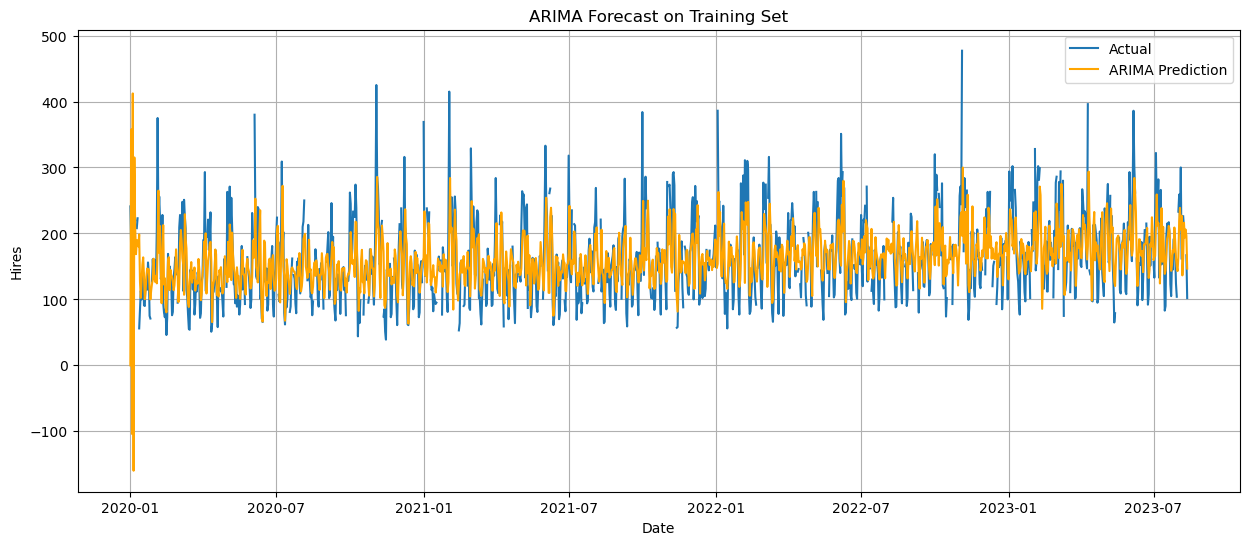

In [16]:
# Plot
figure(figsize=(15, 6))
plt.plot(original_values, label='Actual')
plt.plot(train_pred, color='orange', label='ARIMA Prediction')
plt.legend(loc='best')
plt.title('ARIMA Forecast on Training Set')
plt.xlabel('Date')
plt.ylabel('Hires')
plt.grid(True)
plt.show()

In [17]:
# Function to check autocorrelation (Ljung-Box Test)
message, result = test_ljung_box(results_arima.resid, lags=[10]) 
print(message)
print(result)

No evidence of autocorrelation found (p-value = nan).
    lb_stat  lb_pvalue
10      NaN        NaN


In [18]:
# Model metrics
# Training
rmse_train_arima = np.sqrt(mean_squared_error(original_values, train_pred))
mdae_train_arima = median_absolute_error(original_values, train_pred)
print(f"Train - ARIMA - RMSE: {rmse_train_arima:.2f} | MDAE: {mdae_train_arima:.2f}")

# Validation
val_pred = results_arima.predict(start=val.index[0], end=val.index[-1])
original_val_values = val['contratacoes']
rmse_val_arima = np.sqrt(mean_squared_error(original_val_values, val_pred))
mdae_val_arima = median_absolute_error(original_val_values, val_pred)
print(f"Validation - ARIMA - RMSE: {rmse_val_arima:.2f} | MDAE: {mdae_val_arima:.2f}")

# Test
test_pred = results_arima.predict(start=test.index[0], end=test.index[-1])
original_test_values = test['contratacoes']
rmse_test_arima = np.sqrt(mean_squared_error(original_test_values, test_pred))
mdae_test_arima = median_absolute_error(original_test_values, test_pred)
print(f"Test - ARIMA - RMSE: {rmse_test_arima:.2f} | MDAE: {mdae_test_arima:.2f}")

ValueError: Input contains NaN.

#### 6.2. SARIMA MODEL 

In [ ]:
# SARIMA Model 
# Configuration 
order = (6, 0, 6)             # (p, d, q)
seasonal_order = (1, 1, 1, 12)  # (P, D, Q, s)

# Model training
model_sarima = SARIMAX(train['contratacoes'],
                       order=order,
                       seasonal_order=seasonal_order,
                       enforce_stationarity=False,
                       enforce_invertibility=True)
# Training
results_sarima = model_sarima.fit(disp=False)

In [ ]:
# Forecast on Training Set
train_pred = results_sarima.predict(start=train.index[0], end=train.index[-1])
true_values = train['contratacoes']

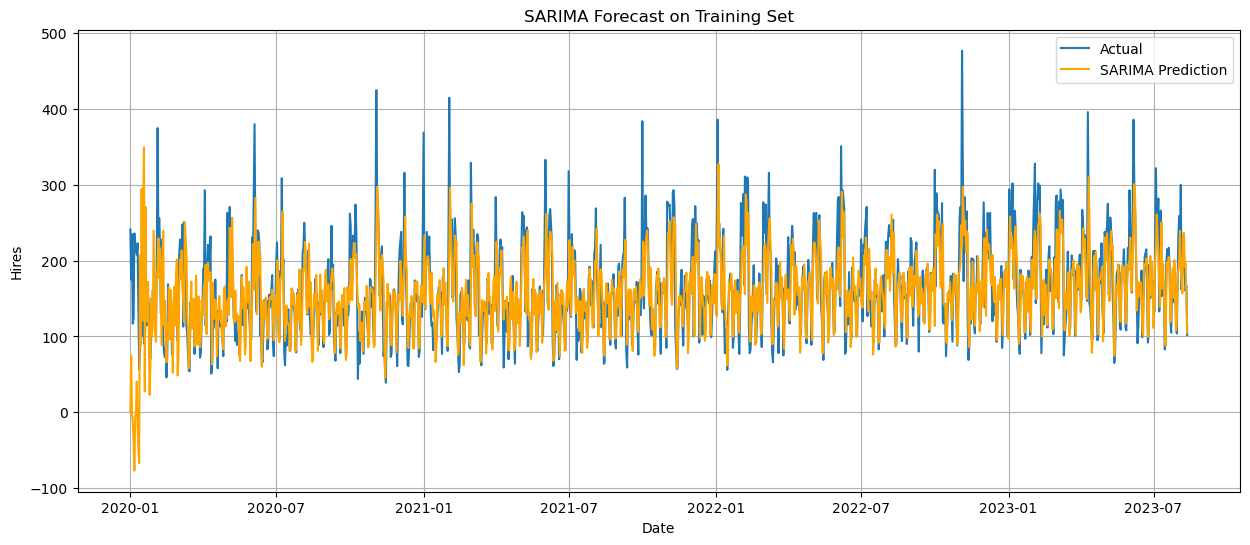

In [ ]:
# Plot
figure(figsize=(15, 6))
plt.plot(true_values, label='Actual')
plt.plot(train_pred, color='orange', label='SARIMA Prediction')
plt.legend(loc='best')
plt.title('SARIMA Forecast on Training Set')
plt.xlabel('Date')
plt.ylabel('Hires')
plt.grid(True)
plt.show()

In [ ]:
# Function to check autocorrelation (Ljung-Box Test)
message, result = test_ljung_box(results_sarima.resid, lags=[10]) 
print(message)
print(result)

Evidence of autocorrelation found (p-value = 0.0000).
       lb_stat     lb_pvalue
10  150.403974  3.078240e-27


In [ ]:
# Model metrics
# Training
original_values = train['contratacoes']
rmse_train_sarima = np.sqrt(mean_squared_error(original_values, train_pred))
mdae_train_sarima = median_absolute_error(original_values, train_pred)
print(f"Train - SARIMA - RMSE: {rmse_train_sarima:.2f} | MDAE: {mdae_train_sarima:.2f}")

# Validation
val_pred = results_sarima.predict(start=val.index[0], end=val.index[-1])
original_val_values = val['contratacoes']
rmse_val_sarima = np.sqrt(mean_squared_error(original_val_values, val_pred))
mdae_val_sarima = median_absolute_error(original_val_values, val_pred)
print(f"Validation - SARIMA - RMSE: {rmse_val_sarima:.2f} | MDAE: {mdae_val_sarima:.2f}")

# Test
test_pred = results_sarima.predict(start=test.index[0], end=test.index[-1])
original_test_values = test['contratacoes']
rmse_test_sarima = np.sqrt(mean_squared_error(original_test_values, test_pred))
mdae_test_sarima = median_absolute_error(original_test_values, test_pred)
print(f"Test - SARIMA - RMSE: {rmse_test_sarima:.2f} | MDAE: {mdae_test_sarima:.2f}")

Train - SARIMA - RMSE: 47.49 | MDAE: 21.10
Validation - SARIMA - RMSE: 59.37 | MDAE: 28.31
Test - SARIMA - RMSE: 70.64 | MDAE: 34.22


### END OF STATISTICAL MODELING
Concluímos a etapa de modelagem estatística, na qual o modelo SARIMA apresentou o melhor desempenho entre as abordagens avaliadas até o momento. Na Parte III do projeto, avançaremos para a implementação de modelos baseados em deep learning, buscando aprimorar ainda mais a capacidade preditiva.